# Modeling

## Import Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC

from IPython.display import clear_output

%matplotlib inline

Next we read in the data and remove redundent index columns.

In [2]:
df = pd.read_csv('./data/combined_df.csv')

In [3]:
df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'subreddit'], inplace = True)

In [4]:
df.head()

,title,onion
0,Horrified Anti-Vaxxer Discovers Every American...,1
1,"Holy Shit, Man Walks on the Fucking Moon",1
2,Signs It’s Time To Put Your Parents In A Nursi...,1
3,Taliban Criticized For Failure To Include Dive...,1
4,Nation’s Dads Announce Plans To Trade In The D...,1


## Vectorization

In [5]:
tvec = TfidfVectorizer(stop_words = 'english')

df_tfid = pd.DataFrame(tvec.fit_transform(df['title']).todense(), columns = tvec.get_feature_names())

In [6]:
df_tfid.shape

(30152, 26880)

In order to reduce processing time we drop tfidf objects with lower values.  These correspond to words that are not prevalent enough to have much impact on the classification algorithms.  By removing these we also greatly reduce processing time.

In [7]:
# Note that this cell take about 10 minutes to run.

drop_list = []
for column in df_tfid.columns:
    word_score = df_tfid[column].sum()
    if word_score < 50:
        clear_output()
        print(column , word_score)
        drop_list.append(column)


휴게텔 0.17530435651772988


In [8]:
X = df_tfid.drop(columns = drop_list)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, df['onion'], random_state = 42, stratify = df['onion'], test_size = 0.3)

In [10]:
X_test.shape

(9046, 127)

## Models

### SVC

First we try an SVC model.

In [11]:
svc = SVC()

In [12]:
svc.fit(X_train, y_train)

SVC()

### Random Forest

For the Random Forest model we will do a grid search to look for the best parameters.

In [13]:
rf = RandomForestClassifier()

rf_params = {
    'n_estimators' : [150, 200, 250],
    'max_depth' : [9, 10, 11],
    'max_features' : ['sqrt']
}

gs = GridSearchCV(rf, rf_params, cv = 5, n_jobs = -1, verbose = 2)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.6739792162779077


{'max_depth': 11, 'max_features': 'sqrt', 'n_estimators': 200}

### Logistic Regression

For the logistic regression model we need to use the standard scaler to adjust our TFIDF values.

In [14]:
ss = StandardScaler()

Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

logreg = LogisticRegression()

logreg.fit(Z_train, y_train)

LogisticRegression()

### Make Predictions

Next we will make predictions using the three models we've fit and examine the confusion matrices to see which models perform best.

In [15]:
y_svc = svc.predict(X_test)
y_rf = gs.predict(X_test)
y_lr = logreg.predict(Z_test)

In [16]:
probs = (y_svc + y_rf + y_lr) / 3

SVC RESULTS
The Accuracy is: 0.705505195666593 
The Recall is: 0.5637732506643047 
The Precision is: 0.7858024691358024 
The F1 Score is: 0.6565239814337287


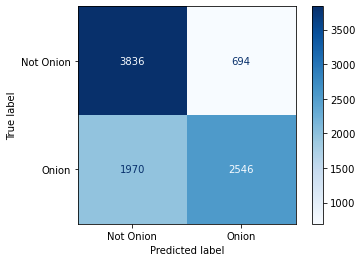

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, y_svc).ravel()

acc = (tp + tn) / (tp + tn + fp + fn)
rec = tp / (tp + fn)
prec = tp / (tp + fp)
f_1 = tp / (tp + 0.5 * (fp + fn))

print("SVC RESULTS")
print(f"The Accuracy is: {acc} \nThe Recall is: {rec} \nThe Precision is: {prec} \nThe F1 Score is: {f_1}")


plot_confusion_matrix(svc, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Not Onion', 'Onion']);

LOGISTIC REGRESSION RESULTS
The Accuracy is: 0.6853858058810524 
The Recall is: 0.5617803365810452 
The Precision is: 0.7452996474735605 
The F1 Score is: 0.6406565656565657


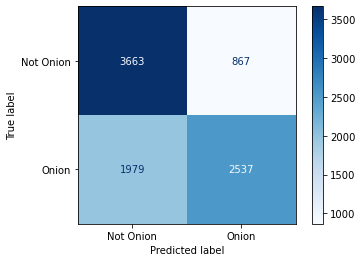

In [18]:
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()

acc = (tp + tn) / (tp + tn + fp + fn)
rec = tp / (tp + fn)
prec = tp / (tp + fp)
f_1 = tp / (tp + 0.5 * (fp + fn))

print("LOGISTIC REGRESSION RESULTS")
print(f"The Accuracy is: {acc} \nThe Recall is: {rec} \nThe Precision is: {prec} \nThe F1 Score is: {f_1}")

plot_confusion_matrix(logreg, Z_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Not Onion', 'Onion']);

RANDOM FOREST RESULTS
The Accuracy is: 0.6749944726951138 
The Recall is: 0.48516386182462357 
The Precision is: 0.7808267997148967 
The F1 Score is: 0.5984703632887189


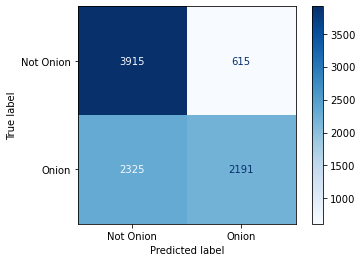

In [19]:
tn, fp, fn, tp = confusion_matrix(y_test, y_rf).ravel()

acc = (tp + tn) / (tp + tn + fp + fn)
rec = tp / (tp + fn)
prec = tp / (tp + fp)
f_1 = tp / (tp + 0.5 * (fp + fn))

print("RANDOM FOREST RESULTS")
print(f"The Accuracy is: {acc} \nThe Recall is: {rec} \nThe Precision is: {prec} \nThe F1 Score is: {f_1}")

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Not Onion', 'Onion']);

In [20]:
tn, fp, fn, tp = confusion_matrix(y_test, (probs > .5).astype(int)).ravel()

acc = (tp + tn) / (tp + tn + fp + fn)
rec = tp / (tp + fn)
prec = tp / (tp + fp)
f_1 = tp / (tp + 0.5 * (fp + fn))

print("ENSEMBLE RESULTS")
print(f"The Accuracy is: {acc} \nThe Recall is: {rec} \nThe Precision is: {prec} \nThe F1 Score is: {f_1}")

ENSEMBLE RESULTS
The Accuracy is: 0.6923502100375857 
The Recall is: 0.5451727192205491 
The Precision is: 0.7715449702287684 
The F1 Score is: 0.6388997015700013


Finally, we examine the words that were most important to the model.

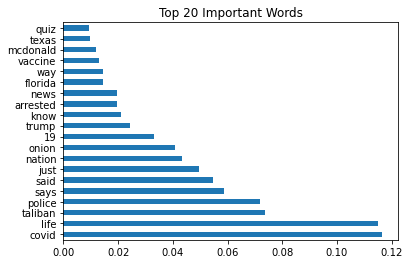

In [21]:
pd.Series(gs.best_estimator_.feature_importances_, X.columns).sort_values(ascending = False).head(20).plot(kind = 'barh', title='Top 20 Important Words');

## Conclusion

Based on these results, the recommended model is the SVM because it is better than every other model in every metric except for the precision of the Random Forest model.  However, the Random Forest model's poor recall and low accuracy disqualify it as the best.